In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib

from ipywidgets import interact, interactive, fixed, interact_manual
from bruges import filters

###  Modelo convolucional 

Sabe-se que o modelo convolucional é descrito pela seguinte Equação:

#### $$p_t = W * Rc + \textit{noise}$$

em que:

   $W$ - É a wavelet;
    
   $Rc$ - É a função refletividade; e
    
   $noise$ - ruído desconhecido
   
A seguir será explicado como o traço sísmico é gerado através de um modelo sintético, sem levar em consideração o fenômeno de absorção de energia nem a presença de ruídos.

----

### Criando um modelo geológico

In [2]:
z = np.arange(0,1000,0.1) #Vetor da profundidade de 100 - 550m
v = np.zeros(len(z))       #Criando um vetor nulo que será armazenado a velocidade
d = np.zeros(len(z))       #Criando um vetor nulo que será armazenado a densidade

In [22]:
#Criando um modelo geologico de camadas
for i in range(0,len(z)):
    if z[i]<=100:
        v[i]=1800 ; d[i]=2.1
    if z[i]>100 and z[i]<=220:
        v[i]=2200 ; d[i]=2.3
    if z[i]>220 and z[i]<=310: 
        v[i]=2500 ; d[i]=2.55
    if z[i]>310 and z[i]<=370: 
        v[i]=2000 ; d[i]=2.4
    if z[i]>370 and z[i]<=390: 
        v[i]=3000 ; d[i]=2.65
    if z[i]>390 and z[i]<=470: 
        v[i]=2500 ; d[i]=2.55
    if z[i]>470 and z[i]<=530: 
        v[i]=3000 ; d[i]=2.65
    if z[i]>530 and z[i]<=590: 
        v[i]=2500 ; d[i] = 2.4
    if z[i]>590: 
        v[i]=4500 ; d[i]=2.75

In [23]:
#Criando um DataFrame
df = pd.DataFrame({'Depth':z,'Vp':v,'Rho':d*1000}) #multiplicando densidade por 1000 (SI)
df.head()

,Depth,Vp,Rho
0,0.0,1800.0,2100.0
1,0.1,1800.0,2100.0
2,0.2,1800.0,2100.0
3,0.3,1800.0,2100.0
4,0.4,1800.0,2100.0


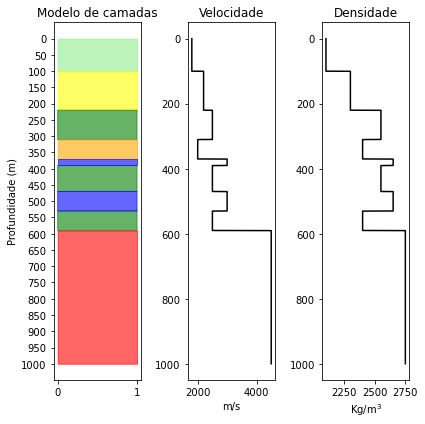

In [24]:
#Plotando o modelo geológico, velocidade e densidade
y_min, y_max, y_step = 0,1000,50

fig,axes = plt.subplots(ncols=3,figsize=(6,6))

for ax in axes:
    ax.invert_yaxis()

color = ['lightgreen','yellow','green','orange','blue','red']
for i,j in zip(df.Vp.unique(),color):
    axes[0].fill_betweenx(y=df.Depth,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j,
                     alpha=0.6)
    
axes[0].set_ylabel('Profundidade (m)')
axes[0].set_title('Modelo de camadas')
axes[0].set_yticks(np.arange(y_min,y_max+y_step,y_step))

axes[1].plot(df.Vp,df.Depth,color='black')
axes[1].set_title('Velocidade')

axes[1].set_xlabel('m/s')
axes[2].plot(df.Rho,df.Depth,color='black')
axes[2].set_xlabel('Kg/m$^3$')
axes[2].set_title('Densidade')

fig.tight_layout()

Antes de calcular o coeficiente de reflexão, precisamos definir  impedância acústica. A <b>impedância acústica</b> ($AI$) é definida em função da velocidade ($v$) e da densidade ($\rho$), e em geral, quanto maior a impedância acústica, "mais rigida" é a rocha (<a href="https://www.geologiabr.com/livros/geofisica-de-exploracao"> Kearey et.al, 2009 </a>):

$$ AI = v \cdot \rho $$

O <b> coeficiente de reflexão </b> ($R_c$) é um efeito numérico da interface sobre a propagação de onda, e tem a ver com as proporções relativas de energia transmitida e refletida. Para um raio que incide normalmente (ângulo de 90°) sobre uma camada, pode ser definido como:

### <center> </center>

$$ R_c = \frac{V_{2}\cdot\rho_{2}-V_{1} \cdot \rho_{1}}{V_{2}\cdot\rho_{2}+V_{1} \cdot \rho_{1}} = \frac{AI_2-AI_1}{AI_2+AI_1} $$

In [25]:
df['AI'] = df['Vp']*df['Rho'] #Calculando a impedância acústica
df.head()

,Depth,Vp,Rho,AI
0,0.0,1800.0,2100.0,3780000.0
1,0.1,1800.0,2100.0,3780000.0
2,0.2,1800.0,2100.0,3780000.0
3,0.3,1800.0,2100.0,3780000.0
4,0.4,1800.0,2100.0,3780000.0


In [26]:
#Calculando o coeficiente de reflexão
Rc = np.zeros(len(df['AI']))
for i in range(0,len(df['AI'])-1):
    Rc[i] = (df['AI'][i+1]-df['AI'][i])/(df['AI'][i+1]+df['AI'][i])
df['Rc'] = Rc
df.head()

,Depth,Vp,Rho,AI,Rc
0,0.0,1800.0,2100.0,3780000.0,0.0
1,0.1,1800.0,2100.0,3780000.0,0.0
2,0.2,1800.0,2100.0,3780000.0,0.0
3,0.3,1800.0,2100.0,3780000.0,0.0
4,0.4,1800.0,2100.0,3780000.0,0.0


Devemos lembrar que no modelo convolucional do traço sísmico temos a representação de interação da onda acústica com uma camada, que é registrada como o tempo duplo (<i>Two way travel time</i>) que a onda percorre da superfície até refletir em uma camada e retornar a superfície para ser registrada por um receptor.

Para estimar o templo duplo (TWT), temos que fazer a soma cumulativa da vagarosidade registrada em poço.

A vagarosidade é o inverso da velocidade acústica:

$$ \Delta t = \frac{1}{v}. $$

Comumente é apresentada em pés por segundo (pé/s), porém sua unidade no SI é dado em metros por segundo (m/s).

In [27]:
#Consideremos a velocidade média dos 100 primeiros metros 1700
df['Dt_SI'] = 1/df['Vp'] #Obtendo a vagarosidade no SI
df['TWT']=(2*100/1700) + 2*(df['Depth'][1]-df['Depth'][0])*np.cumsum(df['Dt_SI']) #Calculando o Two-way-travel time
df.head()

,Depth,Vp,Rho,AI,Rc,Dt_SI,TWT
0,0.0,1800.0,2100.0,3780000.0,0.0,0.000556,0.117758
1,0.1,1800.0,2100.0,3780000.0,0.0,0.000556,0.117869
2,0.2,1800.0,2100.0,3780000.0,0.0,0.000556,0.117980
3,0.3,1800.0,2100.0,3780000.0,0.0,0.000556,0.118092
4,0.4,1800.0,2100.0,3780000.0,0.0,0.000556,0.118203


In [28]:
df.TWT.max()

0.8174713012478454

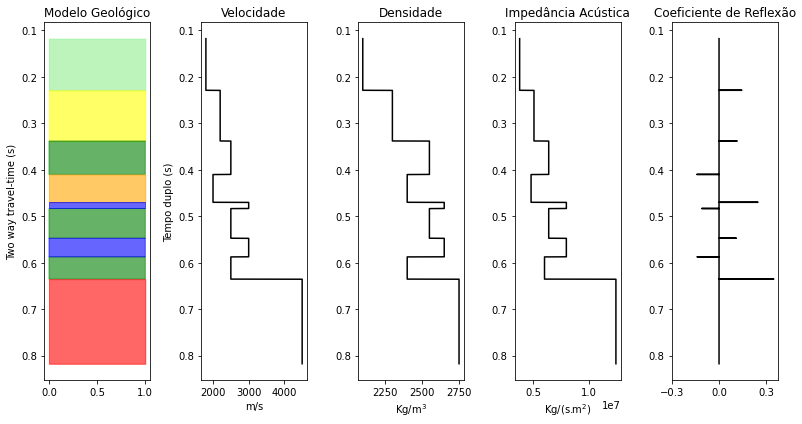

In [29]:
#Plotando modelo e o coeficiente de reflexão
fig,axes = plt.subplots(ncols=5,figsize=(11,6))

for ax in axes:
    ax.invert_yaxis()

for i,j in zip(df.Vp.unique(),color):
    axes[0].fill_betweenx(y=df.TWT,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j,
                     alpha=0.6)
    
axes[0].set_title('Modelo Geológico')
axes[0].set_ylabel('Two way travel-time (s)')
    
axes[1].plot(df.Vp,df.TWT,color='black')
axes[1].set_title('Velocidade')
axes[1].set_xlabel('m/s')
axes[1].set_ylabel('Tempo duplo (s)')

axes[2].plot(df.Rho,df.TWT,color='black')
axes[2].set_title('Densidade')
axes[2].set_xlabel('Kg/m$^3$')

axes[3].plot(df.AI,df.TWT,color='black')
axes[3].set_title('Impedância Acústica')
axes[3].set_xlabel('Kg/(s.m$^2$)')

axes[4].plot(df.Rc,df.TWT,color='black')
axes[4].set_title('Coeficiente de Reflexão')
axes[4].set_xticks(np.arange(-0.3,0.3+0.3,0.3))

fig.tight_layout()

### Reamostrando o dado

Vamos criar um traço sintético com taxa de amostragem igual a $\Delta t = 2ms$. Para isso, teremos que reamostrar o nosso dado sintético.

In [30]:
#Reamostrando a impedância acústica para uma taxa de amostragem de 2ms
dt = 0.002
t = np.arange(0,df.TWT.max()+dt,dt)
Vp = np.interp(x=t,xp=df['TWT'],fp=df['Vp'])
AI = np.interp(x=t,xp=df['TWT'],fp=df['AI'])

In [31]:
#Calculando o coeficiente de reflexão
Rc = np.zeros(len(AI))
for i in range(0,len(Rc)-1):
    Rc[i] = (AI[i+1]-AI[i])/ (AI[i+1]+AI[i])

In [32]:
#Criando um DataFrame com as informações anteriores
trace = pd.DataFrame({'Time':t,
                      'Vp':Vp,
                     'AI':AI,
                     'Rc':Rc})
trace.head()

,Time,Vp,AI,Rc
0,0.000,1800.0,3780000.0,0.0
1,0.002,1800.0,3780000.0,0.0
2,0.004,1800.0,3780000.0,0.0
3,0.006,1800.0,3780000.0,0.0
4,0.008,1800.0,3780000.0,0.0


### Criando uma wavelet de fase zero

É importante lembrar que fontes reais como <i>vibroseis</i> e <i>airguns</i> produzem assinaturas de fase minima. A wavelet de fase minima é aquela que não tem nenhuma energia registrada antes do tempo zero.

Para efeitos didáticos, será criada uma wavelet de fase zero, aquela cujo o pico de amplitude está centrada em zero e com polaridade positiva (padrão americano).

In [40]:
trace.Vp.unique()

array([1800.        , 2200.        , 2349.2869875 , 2500.        ,
       2300.95068329, 2000.        , 2597.14795023, 3000.        ,
       4500.        ])

In [41]:
t_min,t_max, t_step = 0.05, 0.75, 0.05

def wavelet_comp(df,wave_type,duration,f1,f2,f3,f4,t_min=t_min,t_max=t_max,t_step=t_step,dt=0.002):
    fig,axes = plt.subplots(ncols=4,figsize=(8,5))

    for ax in axes:
        ax.set_ylim(t_min,t_max,t_step)
        ax.invert_yaxis()
        
    color = ['lightgreen','yellow','green','orange','green','blue','orange','orange','red']
    
    for i,j in zip(df.Vp.unique(),color):
        axes[0].fill_betweenx(y=df.Time,
                         x1=1,
                         x2=0,
                         where=df.Vp==i,
                         color=j,
                     alpha=0.6)

    axes[1].plot(df.Rc,df.Time,color='black')
    axes[1].set_title('Coeficiente de Reflexão')

    if wave_type =='ricker':
        wave,t_wave = wave_ormsby,t_wave = filters.wavelets.ricker(duration=duration,dt=dt,f=f1,return_t=True)
    
    if wave_type =='ormsby':
        wave,t_wave = wave_ormsby,t_wave = filters.wavelets.ormsby(duration=duration,dt=dt,f=[f1,f2,f3,f4],return_t=True)
    
    if wave_type =='gabor':
        wave,t_wave = wave_ormsby,t_wave = filters.wavelets.gabor(duration=duration,dt=dt,f=f1,return_t=True)
        
    axes[2].plot(wave,t_wave,color='black')
    axes[2].fill_betweenx(y=t_wave,
                     x1=wave,
                     x2=0,
                     where=wave>0,color='blue')

    axes[2].plot(wave,t_wave,color='black')
    axes[2].fill_betweenx(y=t_wave,
                     x1=wave,
                     x2=0,
                     where=wave<0,color='red')

    axes[2].set_ylim(t_wave.min(),t_wave.max())

    axes[2].set_title('Wavelet')
    
    trace = np.convolve(wave,df.Rc,mode='same')
    
    axes[3].plot(trace,df.Time,color='black')
    
    axes[3].fill_betweenx(y=df.Time,
                 x1=trace,
                 x2=0,
                 where=trace>0,color='blue')
    
    axes[3].fill_betweenx(y=df.Time,
                 x1=trace,
                 x2=0,
                 where=trace<0,color='red')

    axes[3].set_title('Traço Sísmico')

    fig.text(x=0.50,y=0.5,s='*',fontsize=16)

    fig.text(x=0.76,y=0.5,s='=',fontsize=16)

    fig.tight_layout()

In [42]:
trace.Vp.unique()

array([1800.        , 2200.        , 2349.2869875 , 2500.        ,
       2300.95068329, 2000.        , 2597.14795023, 3000.        ,
       4500.        ])

In [43]:
@interact(duration_ms=(128,512,64),
                 f1_hz=(0,150,2.5),
                 f2_hz=(5,155,2.5),
                 f3_hz=(10,160,2.5),
                 f4_hz=(15,165,2.5),
         wave_type=['ricker','ormsby','gabor'])
def update(wave_type,duration_ms,f1_hz,f2_hz,f3_hz,f4_hz):
    wavelet_comp(trace,wave_type,duration_ms/1000,f1_hz,f2_hz,f3_hz,f4_hz)

interactive(children=(Dropdown(description='wave_type', options=('ricker', 'ormsby', 'gabor'), value='ricker')…